In [4]:
import numpy as np
import cv2
import torch
import os
from time import time

import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
VIDEO_PATH = 'data/car_video.mp4'

In [6]:
def get_face_detector():
    cascade_path = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_default.xml"
    return cv2.CascadeClassifier(cascade_path)

def get_faces(frame, detector):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(
        gray_frame,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(25, 25),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return faces

In [7]:
def score_frame(frame, model):
    results = model(frame)
    labels = results.xyxyn[0][:, -1].numpy()
    coordinates = results.xyxyn[0][:, :-1].numpy()
    return labels, coordinates

def validate_ratio(rect):
    (x, y), (width, height), rect_angle = rect

    if (width > height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle
    
    if abs(angle) > 15:
        return False

    if (height == 0 or width == 0):
        return False
    
    ratio = width / height

    return ratio > 2.5 and ratio < 7

def validate_contour(contour):
    min_rect = cv2.minAreaRect(contour)
    return validate_ratio(min_rect)

def get_license_plates(frame):
    frame_preproc = cv2.GaussianBlur(frame, (9, 9), 0)
    frame_preproc = cv2.cvtColor(frame_preproc, cv2.COLOR_BGR2GRAY)
    frame_preproc = cv2.Sobel(frame_preproc, cv2.CV_8U, 1, 0, ksize=3)
    _, frame_preproc = cv2.threshold(frame_preproc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    frame_morph = cv2.morphologyEx(
        src = frame_preproc,
        op = cv2.MORPH_CLOSE,
        kernel = cv2.getStructuringElement(
            shape = cv2.MORPH_RECT, 
            ksize =(30, 10)
        )
    )
    contours, _ = cv2.findContours(
        frame_morph,
        mode = cv2.RETR_EXTERNAL,
        method = cv2.CHAIN_APPROX_NONE
    )
    valid_contours = [x for x in contours if validate_contour(x)]
    plates = []
    X, Y = frame.shape[1], frame.shape[0]
    for contour in valid_contours:
        min_rect = cv2.minAreaRect(contour)
        (x, y), (w, h), _ = min_rect
        x = int(x)
        y = int(y)
        w = int(w) + 16
        h = int(h) + 16
        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(x + w // 2, X)
        y2 = min(y + h // 2, Y)
        plate = frame[y1 : y2, x1 : x2]
        im = Image.fromarray(plate)
        plate_number = pytesseract.image_to_string(im)
        if len(plate_number) > 4 and len(plate_number) < 15:
            plates.append(((x1, y1), (x2, y2), plate_number))
    return plates

In [8]:
def plot_boxes(labels, coordinates, frame, model):
    n = len(labels)
    x_shape, y_shape = frame.shape[1], frame.shape[0]
    for i in range(n):
        row = coordinates[i]
        # If score is less than 0.5 we avoid making a prediction.
        if row[4] < 0.2: 
            continue
        x1 = int(row[0] * x_shape)
        y1 = int(row[1] * y_shape)
        x2 = int(row[2] * x_shape)
        y2 = int(row[3] * y_shape)
        box_bgr = (0, 255, 0) # color of the box
        classes = model.names # Get the name of label index
        label_font = cv2.FONT_HERSHEY_SIMPLEX # Font for the label.
        cv2.rectangle(
            frame, 
            (x1, y1), (x2, y2), 
            box_bgr, 2
        ) # Plot the boxes
        cv2.putText(
            frame,
            classes[labels[i]],
            # f"{classes[labels[i]]}: {row[4] * 100: .2f}%", 
            (x1, y1), 
            label_font, 0.9, box_bgr, 2
        ) # Put a label over box.
    return frame

In [9]:
def plot_plates(plates, frame):
    for plate in plates:
        (x1, y1), (x2, y2), plate_number = plate 
        box_bgr = (0, 255, 255) # color of the box
        label_font = cv2.FONT_HERSHEY_SIMPLEX # Font for the label.
        cv2.rectangle(
            frame, 
            (x1, y1), (x2, y2), 
            box_bgr, 5
        )
        cv2.putText(
            frame,
            plate_number, 
            (x1, y1), 
            label_font, 0.9, box_bgr, 2
        ) # Put a label over box.
    return frame

In [10]:
def plot_faces(faces, frame):
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 255), 2)
    return frame

In [11]:
def frame_diff(base_frame, current_frame):
    base_frame_grey = cv2.cvtColor(base_frame, cv2.COLOR_BGR2GRAY)
    current_frame_grey = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(current_frame_grey, base_frame_grey)
    return (np.count_nonzero(frame_diff >= 75) / frame_diff.size) > 0.1

In [15]:
def process_video(input_path, out_path, model):
    input_video = cv2.VideoCapture(input_path)
    x_shape = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    y_shape = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    four_cc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(out_path, four_cc, 30, (x_shape, y_shape)) 
    print(out.isOpened())
    read_frame, frame = input_video.read() # Read the first frame.
    base_frame = frame.copy()
    counter = 0
    start_time = time() # We would like to measure the FPS.
    labels, coordinates = score_frame(frame, model)  
    plates = get_license_plates(frame)
    face_detector = get_face_detector()
    faces = get_faces(frame, face_detector)
    while read_frame: # Run until stream is out of frames
        if counter % 20 == 0 or frame_diff(base_frame, frame):
            base_frame = frame.copy()
            labels, coordinates = score_frame(frame, model) 
            plates = get_license_plates(frame)
            faces = get_faces(frame, face_detector)
        counter += 1
        out_frame = plot_boxes(labels, coordinates, frame.copy(), model) # Plot the boxes.
        out_frame = plot_plates(plates, out_frame.copy())
        out_frame = plot_faces(faces, out_frame.copy())
        if counter % 100 == 0:
            end_time = time()
            fps = 100 / np.round(end_time - start_time, 3) # Measure the FPS.
            print(f"Frames Per Second : {fps}")
            start_time = time() # We would like to measure the FPS.
        out.write(out_frame) # Write the frame onto the output.
        read_frame, frame = input_video.read() # Read next frame.
    # out.release()
    # input_video.release()

In [16]:
model = torch.hub.load(
    'ultralytics/yolov5',
    'yolov5s',
    pretrained=True,
)

Using cache found in C:\Users\stast/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-15 Python-3.8.12 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [17]:
process_video(VIDEO_PATH, "data/video_out.mp4", model)

True
Frames Per Second : 6.067961165048543
Frames Per Second : 6.041200990756963
Frames Per Second : 5.801473574287869
Frames Per Second : 4.175191014988935
Frames Per Second : 3.4224306102193776
Frames Per Second : 5.437146585471944
Frames Per Second : 7.056665020111495
Frames Per Second : 7.221780891167763
Frames Per Second : 8.41609156707625
Frames Per Second : 6.012506012506012
Frames Per Second : 5.4336013910019565
Frames Per Second : 7.125552230297847


In [10]:
reader = cv2.VideoCapture(VIDEO_PATH)
_, frame = reader.read()
reader.release()

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

## Number Plate Detection

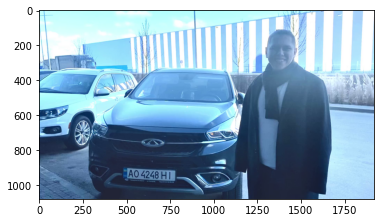

In [12]:
plt.imshow(frame[:,:,::-1])
plt.show()

First step of detection is applying Gaussian Blur to video frame and converting color to greyscale

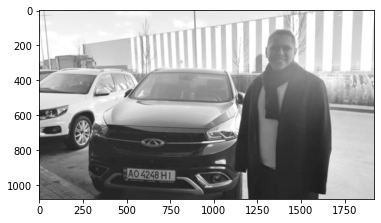

In [20]:
frame_preproc = cv2.GaussianBlur(frame, (9, 9), 0)
frame_preproc = cv2.cvtColor(frame_preproc, cv2.COLOR_BGR2GRAY)
plt.imshow(frame_preproc, cmap='gray', vmin=0, vmax=255)
plt.show()

Second step is finding vertical object edges on greyscale image. Using Sobel operator with vertical filter (kernel size 3). 

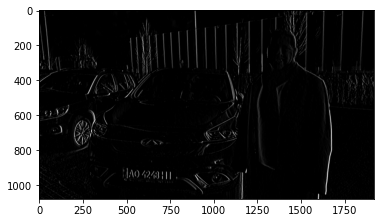

In [21]:
frame_preproc = cv2.Sobel(frame_preproc, cv2.CV_8U, 1, 0, ksize=3)
plt.imshow(frame_preproc, cmap='gray', vmin=0, vmax=255)
plt.show()

Refining vertical edges structure using Otsu binarization.

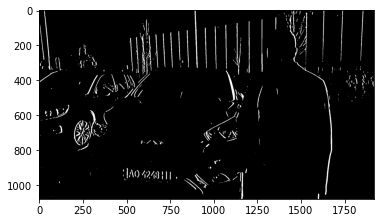

In [22]:
_, frame_preproc = cv2.threshold(frame_preproc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(frame_preproc, cmap='gray', vmin=0, vmax=255)
plt.show()

Using morphological closing with rectangular shape we can find rectangular blocks of vertical edges on image. Number plate is expected to be one of these blocks.

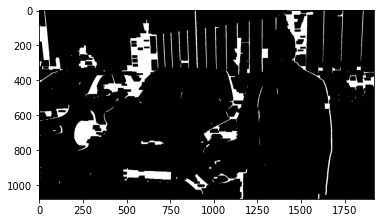

In [23]:
frame_morph = cv2.morphologyEx(
    src = frame_preproc,
    op = cv2.MORPH_CLOSE,
    kernel = cv2.getStructuringElement(
        shape = cv2.MORPH_RECT, 
        ksize = (30, 10)
    )
)
plt.imshow(frame_morph, cmap='gray', vmin=0, vmax=255)
plt.show()

In [24]:
contours, _ = cv2.findContours(
    frame_morph,
    mode = cv2.RETR_EXTERNAL,
    method = cv2.CHAIN_APPROX_NONE
)

In [25]:
valid_contours = [x for x in contours if validate_contour(x)]

BAO 4248 H |

Tas



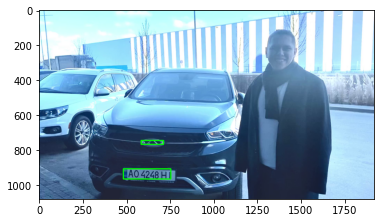

In [26]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract\tesseract.exe'
from PIL import Image

to_draw = frame.copy()
for contour in valid_contours:
    min_rect = cv2.minAreaRect(contour)
    (x, y), (w, h), _ = min_rect
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    cv2.rectangle(
        to_draw, 
        (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), 
        (0, 255, 0), 5
    )
    plate = frame[y - h // 2 : y + h // 2, x - w // 2 : x + w // 2]
    im = Image.fromarray(plate)
    print(pytesseract.image_to_string(im))
plt.imshow(to_draw[:,:,::-1])
plt.show()